In [1]:
import matplotlib.pyplot as plt

In [4]:
from bluesky.plans import grid_scan
from ophyd.sim import det5, jittery_motor1, jittery_motor2
from bluesky.callbacks.mpl_plotting import LiveScatter

# The 'jittery' example motors won't go exactly where they are told to go.
from bluesky import RunEngine

RE = RunEngine({})
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

from databroker import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)



1



Transient Scan ID: 3     Time: 2023-06-15 21:42:17
Persistent Unique Scan ID: '882600f3-2aa0-4913-ae44-599529f5e314'


c:\Users\qqu\Bluesky_dev\sissy_plans\.venv\lib\site-packages\bluesky\callbacks\mpl_plotting.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


New stream: 'primary'
+-----------+------------+----------------+----------------+------------+
|   seq_num |       time | jittery_motor1 | jittery_motor2 |       det5 |
+-----------+------------+----------------+----------------+------------+
|         1 | 21:42:17.4 |         -2.167 |         -4.570 |      0.000 |
|         2 | 21:42:17.5 |         -2.167 |         -3.538 |      0.000 |
|         3 | 21:42:17.6 |         -2.167 |         -2.315 |      0.007 |
|         4 | 21:42:17.7 |         -2.167 |         -1.125 |      0.051 |
|         5 | 21:42:17.8 |         -2.167 |         -0.308 |      0.091 |
|         6 | 21:42:17.8 |         -2.167 |          0.755 |      0.072 |
|         7 | 21:42:17.9 |         -2.167 |          2.471 |      0.005 |
|         8 | 21:42:18.0 |         -2.167 |          2.979 |      0.001 |
|         9 | 21:42:18.0 |         -2.167 |          4.272 |      0.000 |
|        10 | 21:42:18.1 |         -2.167 |          5.924 |      0.000 |
|        11 | 21

('882600f3-2aa0-4913-ae44-599529f5e314',)

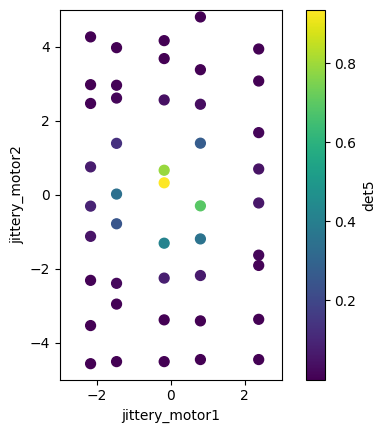

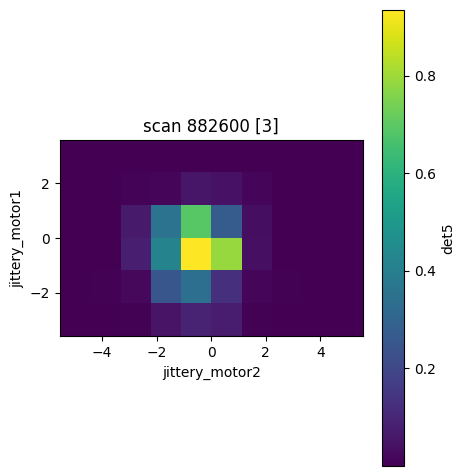

In [7]:

RE(grid_scan([det5],
                      jittery_motor1, -3, 3, 6,
                      jittery_motor2, -5, 5, 10, True),
   LiveScatter('jittery_motor1', 'jittery_motor2', 'det5',
            xlim=(-3, 3), ylim=(-5, 5)))

**From non-uniform to uniform**

We want to go from a non-uniformly spaced dataset, to a uniformly spaced one. Let's do it in one dimension


[-4.20742033 -3.8094394  -2.171869   -1.11822151  0.14511595  0.7341482
  2.439064    3.29238681  4.54158028  5.24024912]


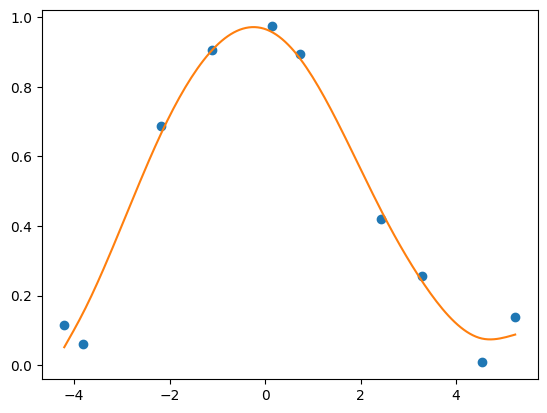

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from csaps import csaps


def univariate_data(n=25, seed=1234):
    np.random.seed(seed)
    x = np.linspace(-5., 5., n)
    y = np.exp(-(x/2.5)**2) + (np.random.rand(n) - 0.2) * 0.3
    return x, y

def univariate_non_uniform_data(n=25, seed=1234):
    np.random.seed(seed)
    x = np.linspace(-5., 5., n)+(np.random.rand(n)) * 0.9

    #enforce monotonic
    x = np.sort(x)
    print(x)
    y = np.exp(-(x/2.5)**2) + (np.random.rand(n) - 0.2) * 0.3
    return x, y

x, y = univariate_non_uniform_data(n=10, seed=12344534)
xi = np.linspace(x[0], x[-1], 150)

yi = csaps(x, y, xi, smooth=0.85)

plt.plot(x, y, 'o', xi, yi, '-')

**Now in 2 dimensions**



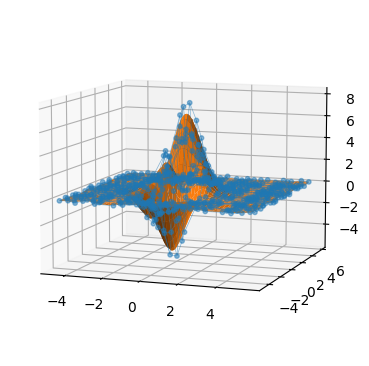

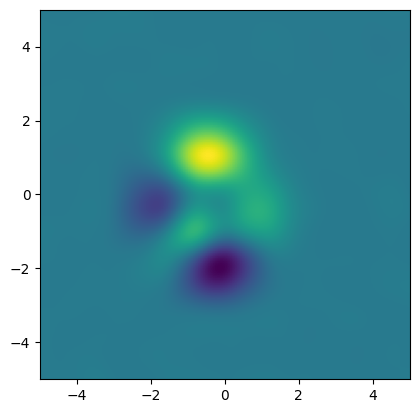

In [71]:



def multiivariate_non_uniform_data(n=25, seed=1234):
    
    #Create x and y dimensions
    np.random.seed(seed)
    x = np.sort(np.linspace(-5., 5., n)+(np.random.rand(n)) * 0.9)
    
    np.random.seed(seed*2)
    y = np.sort(np.linspace(-5., 5., n)+(np.random.rand(n)) * 0.9)

    
    xdata = [x, y ]

    #create meshgrid
    i, j = np.meshgrid(*xdata, indexing='ij')
    ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
            - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
            - 1 / 3 * np.exp(-(j + 1)**2 - i**2))
    
    
    #Add some noise
    np.random.seed(seed*3)
    ydata = ydata + (np.random.randn(*ydata.shape) * 0.1)
    

    
    return xdata,ydata, i,j

xdata, ydata,i,j = multiivariate_non_uniform_data()

#Create the uniformly spaced versions
xi = np.linspace(xdata[0][0], xdata[0][-1], 150)
yi = np.linspace(xdata[1][0], xdata[1][-1], 150)
xdata_i = [xi,yi]
ydata_s = csaps(xdata, ydata, xdata_i, smooth=0.988)

fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('none')
c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
ax.plot_wireframe(j, i, ydata, linewidths=0.5, color=c[0], alpha=0.5)
ax.scatter(j, i, ydata, s=10, c=c[0], alpha=0.5)

#create uniform meshgrid
ii, ji = np.meshgrid(*xdata_i, indexing='ij')
ax.plot_surface(ji, ii, ydata_s, color=c[1], linewidth=0, alpha=1.0)
ax.view_init(elev=9., azim=290)

plt.figure()
plt.imshow(ydata_s, origin="lower",extent=[-5,5,-5,5])


Text(0, 0.5, 'uniform, j')

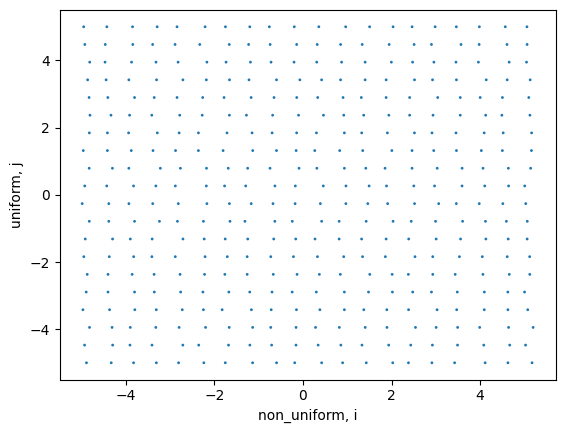

In [122]:
## Even this doesn't really model it because I have a uniform number of samples in each row

n=20

i=[]
for column in range(n):
    seed = 1245*column
    np.random.seed(seed*column)
    column_i = np.sort(np.linspace(-5., 5., n)+(np.random.rand(n)) * 0.2)
    i = np.append(i,column_i)


row_j = np.linspace(-5., 5., n)
j = np.repeat(row_j,n)


ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
            - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
            - 1 / 3 * np.exp(-(j + 1)**2 - i**2))

ones = np.ones(n*n)
plt.scatter(i,j,ones)
plt.xlabel("non_uniform, i")
plt.ylabel("uniform, j")

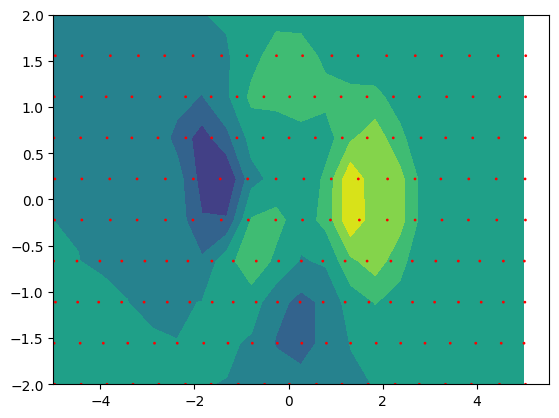

In [184]:
## Even this doesn't really model it because I have a uniform number of samples in each row

n_rows=10
n_columns=20


# This represents the motor that doesn't move continuously
row_j = np.linspace(-2., 2., n_rows)
import random

i=[]
j=[]
for column in range(n_rows):
    seed = 1245*column
    np.random.seed(seed*column)
    m = n_columns+random.randint(-2, 2)
    column_i = np.sort(np.linspace(-5., 5.,m )+(np.random.rand(m)) * 0.05)
    i = np.append(i,column_i)
    j_pos = row_j[column]
    j = np.append(j,np.ones(m)*j_pos)





ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
            - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
            - 1 / 3 * np.exp(-(j + 1)**2 - i**2))

ones = np.ones(len(i))

## Use scipy to interpolate onto a uniform grid

#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)[source]


grid_j = np.linspace(-2., 2., n_rows)
grid_i = np.linspace(-5., 5., n_columns)
X, Y = np.meshgrid(grid_i,grid_j)

from scipy.interpolate import griddata
# Here i and j represent the vectors or points I would get from the motors
# ydata represents the detector data
# X and Y are the points I want to recover determined from the start and stop positions 
Ti = griddata((i,j), ydata, (X,Y), method='nearest')

plt.contourf(X, Y, Ti)
plt.scatter(i,j,ones,'r')


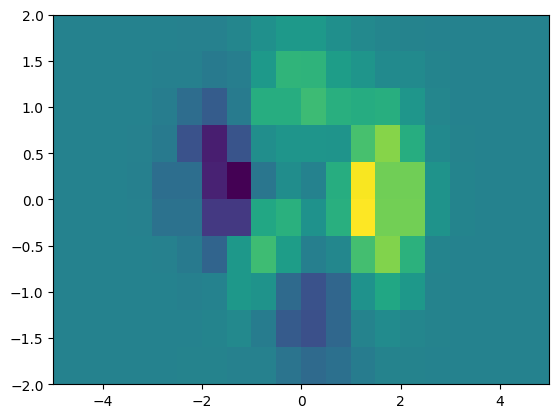

In [194]:
# These extents are wrong, but close enough
plt.imshow(Ti,origin="lower",extent=(-5,5,-2,2),aspect='auto')